<h1>Project 3: Swan Teleco</h1>
<h3>Customer Retention Marketing</h2>

Import Libraries

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
import scipy.stats as stats
from scipy.stats import zscore
from time import time
from tqdm import tqdm
import joblib
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


sns.set_style("whitegrid")




Functions for Model Evaluation

In [100]:
def apr(y_pred, y_real):


    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred,pos_label='1')
    recall = metrics.recall_score(y_real, y_pred,pos_label='1')
    f1 = metrics.f1_score(y_real, y_pred,pos_label='1')
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


##

def produce_confusion(positive_label, negative_label,y_test,y_pred):
    
   
    #Build the CM
    plt.figure(figsize=(7,5))

    cm = metrics.confusion_matrix(y_test, y_pred) 
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
    ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])

    plt.show()


### Import Data

In [60]:
file_name = "data/cleaned_data.csv"
df = pd.read_csv(file_name)
df.shape

(7032, 21)

In [61]:
df.head()

,Count,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Label,Churn Value
0,1,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,1
1,1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes,1
2,1,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,Yes,1
3,1,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,Yes,1
4,1,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,Yes,1


In [62]:
# cols_to_remove =  ['Count','Churn Label','Lat Long','Country','State','City']

# df.drop(columns = cols_to_remove, inplace = True)

# # remove rows with whitespaces as values
# df = df.drop(df[df['Total Charges'] == ' '].index)
# df = df.drop(df[df['Monthly Charges'] == ' '].index)
# df.shape

In [63]:
df.isnull().mean().round(4) * 100

Count                0.0
Gender               0.0
Senior Citizen       0.0
Partner              0.0
Dependents           0.0
Tenure Months        0.0
Phone Service        0.0
Multiple Lines       0.0
Internet Service     0.0
Online Security      0.0
Online Backup        0.0
Device Protection    0.0
Tech Support         0.0
Streaming TV         0.0
Streaming Movies     0.0
Contract             0.0
Paperless Billing    0.0
Payment Method       0.0
Monthly Charges      0.0
Churn Label          0.0
Churn Value          0.0
dtype: float64

In [64]:
df[df['Churn Value'] == 0].shape

(5163, 21)

In [65]:
# Select only the continuous features from the dataset
cont_features = df.select_dtypes(include=['float', 'int']).columns.to_list()
cat_features = df.select_dtypes(include=['object']).columns.to_list()


In [66]:
cont_features

['Count', 'Tenure Months', 'Monthly Charges', 'Churn Value']

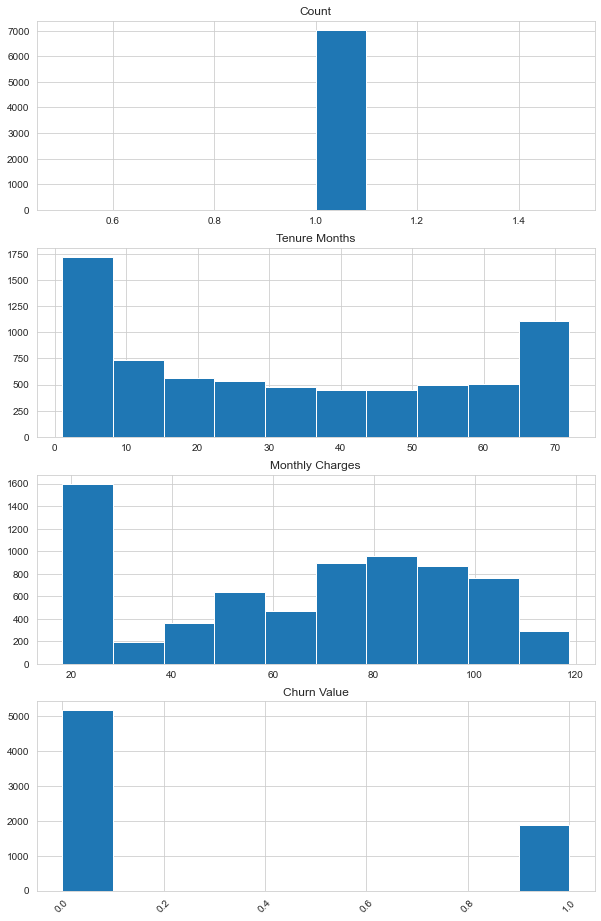

In [67]:
# Get the number of columns in the dataset

cont_df=df[cont_features]

num_columns = cont_df.shape[1]

# Create a figure with a subplot for each column
fig, axes = plt.subplots(num_columns, figsize=(10, num_columns*4))
# Rotate the x-axis labels at an angle
plt.xticks(rotation=45)
# Plot a histogram for each column
for i in range(num_columns):
    column = cont_df.columns[i]
    axes[i].hist(cont_df[column])
    axes[i].set_title(column)
    #axes[i].set_xticks(rotation=45)

plt.show()

In [68]:
df.describe()

,Count,Tenure Months,Monthly Charges,Churn Value
count,7032.0,7032.000000,7032.000000,7032.000000
mean,1.0,32.421786,64.798208,0.265785
std,0.0,24.545260,30.085974,0.441782
min,1.0,1.000000,18.250000,0.000000
25%,1.0,9.000000,35.587500,0.000000
50%,1.0,29.000000,70.350000,0.000000
75%,1.0,55.000000,89.862500,1.000000
max,1.0,72.000000,118.750000,1.000000


# Data Preparation

<li>In this part we split unchurned rows into train and test. This test data will be <i>X_test</i></li>
<li>Then we combine the churned data rows with unchurned train rows to form <i>X_train</i></li>

In [69]:
# split as churned and unchurned datadrames 

churned_df = df.loc[df['Churn Value'] == 1]
unchurned_df = df.loc[df['Churn Value'] == 0]

print(churned_df.shape)
print(unchurned_df.shape)

(1869, 21)
(5163, 21)


In [70]:
df['Churn Value'].value_counts()

0    5163
1    1869
Name: Churn Value, dtype: int64

In [71]:
def feature_engineer(df):


    cols_to_convert = [feature for feature in cont_features if len(df[feature].unique())<4]
    # Convert the columns to string type
    df[cols_to_convert] = df[cols_to_convert].apply(lambda x: x.astype(str))

    # Label encode the columns
    df[cat_features] = df[cat_features].apply(LabelEncoder().fit_transform)

    # Convert the columns to string type
    df[cat_features+cols_to_convert] = df[cat_features+cols_to_convert].apply(lambda x: x.astype(str))

    return df

df_new=feature_engineer(df)
df_new.head()

,Count,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Label,Churn Value
0,1,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,1,1
1,1,0,0,0,1,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,1,1
2,1,0,0,0,1,8,1,2,1,0,...,2,0,2,2,0,1,2,99.65,1,1
3,1,0,0,1,1,28,1,2,1,0,...,2,2,2,2,0,1,2,104.80,1,1
4,1,1,0,0,1,49,1,2,1,0,...,2,0,2,2,0,1,0,103.70,1,1


In [106]:
def undersample(df):

    positive_df = df[df['Churn Value']=='1']
    negative_df = df[df['Churn Value']!='1']
    negative_df=negative_df.sample(n=int((positive_df.shape[0])*1.5))

    df_new=pd.concat([positive_df,negative_df],axis=0)

    features=df_new.columns.to_list()
    features.remove('Churn Value')

    X=df_new[features]
    y=df_new['Churn Value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

    return X_train, X_test, y_train, y_test

    
X_train, X_test, y_train, y_test = undersample(df)
#X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size = 0.2, random_state = 20)
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape) 

X_train shape: (3504, 20)
y_train shape: (3504,)
X_test shape: (1168, 20)
y_test shape: (1168,)


###  Feature Engineering

In [107]:
def feature_eng(df):
    
        df['Monthly Charges'].astype('float').astype('int')
   
    
        # # scaling
        st_scaler = StandardScaler()

        col_transformer = ColumnTransformer(verbose = True, transformers = [('ss', st_scaler, ['Monthly Charges', 'Tenure Months'])])
        depth_transform = col_transformer.fit_transform(df)
        df_scaled = pd.DataFrame(depth_transform,index=df.index, columns =['Monthly Charges', 'Tenure Months'])

        df[['mileage', 'BHP']]  = df_scaled.copy()

        cols_to_ohe = {'Device Protection',
                'Tech Support',
                'Phone Service',
                'Contract',
                'Streaming Movies',
                'Online Security',
                'Dependents',
                'Payment Method',
                'Online Backup',
                'Paperless Billing',
                'Senior Citizen',
                'Multiple Lines',
                'Gender',
                'Partner',
                'Internet Service',
                'Streaming TV'
                }

        # ohe
        for col in cols_to_ohe:

                df = pd.get_dummies(df, columns = [col], drop_first = True, prefix = col)


        return df



In [108]:
X_train.columns

Index(['Count', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Churn Label'],
      dtype='object')

In [109]:
# X_train = feature_eng(X_train)
# X_test = feature_eng(X_test)


len(list(X_train.columns))

20

# Modelling

In [110]:
def get_best_params(X,y):
   """
   Gets the best params
   i/p:X,y
   o/p:params
   """
   rf = RandomForestClassifier(n_estimators=50)
   # Use StratifiedKFold with 5 folds
   skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)


   rf_params = {
   'n_estimators': [150,200,250],
   'max_depth': [ x for x in range(1,len(X.columns))],
   }

   gs = GridSearchCV(rf, param_grid=rf_params, cv=skf,error_score="raise")

   gs.fit(X, y)


   print(gs.best_score_)

   params = gs.best_params_
      
   return params

In [111]:
X_train.head(2)

,Count,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Label
6688,1,0,0,1,1,8,1,0,2,1,1,1,1,1,1,2,0,3,19.5,0
1294,1,1,0,0,0,5,0,1,0,0,2,0,0,2,2,0,1,3,51.0,1


In [112]:
all_cols = set(X_train.columns)

cols_to_remove = {
                    'CustomerID',
                    'Count'
                    'Zip Code',
                    'Lat Long',
                    'Total Charges',
                    'Internet Service_Fiber optic',
                    'Internet Service_No',
                    'Multiple Lines_No phone service',
                    'Latitude',
                    'Longitude',
                    'Churn Label',
                    'Churn Reason'
                    }
cols_filtered = list(all_cols-cols_to_remove)


In [113]:
X_train[cols_filtered].dtypes

Contract              object
Online Security       object
Gender                object
Device Protection     object
Churn Label           object
Streaming TV          object
Count                 object
Phone Service         object
Paperless Billing     object
Streaming Movies      object
Online Backup         object
Multiple Lines        object
Payment Method        object
Partner               object
Dependents            object
Tenure Months          int64
Monthly Charges      float64
Internet Service      object
Senior Citizen        object
Tech Support          object
dtype: object

In [114]:
best_params = get_best_params(X_train[cols_filtered],y_train)

rf_base = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'])
rf_base.fit(X_train[cols_filtered],y_train)


1.0


RandomForestClassifier(max_depth=3, n_estimators=150)

In [115]:
# Get the feature importances
importances = rf_base.feature_importances_

feature_names = cols_filtered

# Print the importances
print(f"Feature importances: {importances}")
print(f"Features: {feature_names}")

Feature importances: [1.20670098e-01 7.20430352e-02 0.00000000e+00 9.75147025e-03
 5.40857147e-01 1.11386403e-03 0.00000000e+00 1.64914258e-04
 2.36897542e-03 1.82436835e-03 1.18584354e-02 5.17816716e-04
 6.20449382e-03 1.40863718e-03 3.38613464e-02 7.81748830e-02
 2.02676947e-02 2.85382255e-02 1.17044301e-04 7.02575509e-02]
Features: ['Contract', 'Online Security', 'Gender', 'Device Protection', 'Churn Label', 'Streaming TV', 'Count', 'Phone Service', 'Paperless Billing', 'Streaming Movies', 'Online Backup', 'Multiple Lines', 'Payment Method', 'Partner', 'Dependents', 'Tenure Months', 'Monthly Charges', 'Internet Service', 'Senior Citizen', 'Tech Support']


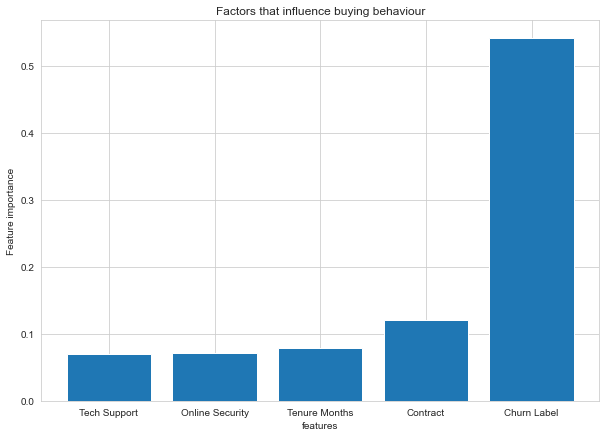

In [116]:
# Zip the lists and sort by the values in list1
sorted_filtered_lists = [tup for tup in sorted(zip(importances, feature_names), key=lambda x: x[0]) if tup[0] >= 0.05]
# Unzip the sorted lists
importances, feature_names = zip(*sorted_filtered_lists)

importances, feature_names = list(importances), list(feature_names)

# Plot the importances

# Set figure size

plt.figure(figsize=(10, 7))
plt.title('Factors that influence buying behaviour')
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(feature_names)), feature_names)
plt.xlabel("features")
plt.ylabel("Feature importance")

plt.show()


In [117]:
best_params

{'max_depth': 3, 'n_estimators': 150}

In [126]:
feature_names

['Tech Support', 'Online Security', 'Tenure Months', 'Contract', 'Churn Label']

In [118]:
imp_features = feature_names

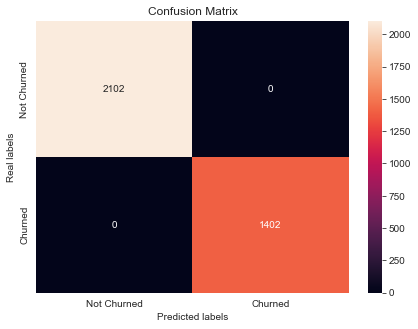

Score: 1.0
Accuracy:1.0
Precision:1.0
Recall:1.0
F1:1.0


In [119]:
best_rf = RandomForestClassifier(n_estimators=250,max_depth=9)
best_rf.fit(X_train[imp_features],y_train)
## Prediction
y_pred = best_rf.predict(X_train[imp_features])


## Predicted Probabilities!
y_pred_prob = best_rf.predict_proba(X_train[imp_features])

produce_confusion('Churned', 'Un-Churned',y_train,y_pred)


print('Score:',best_rf.score(X_train[imp_features],y_train.values))
train_scores = apr(y_pred, y_train)


In [120]:
y_pred

array(['0', '1', '0', ..., '0', '0', '0'], dtype=object)

In [121]:
type(y_train)

pandas.core.series.Series

Test data

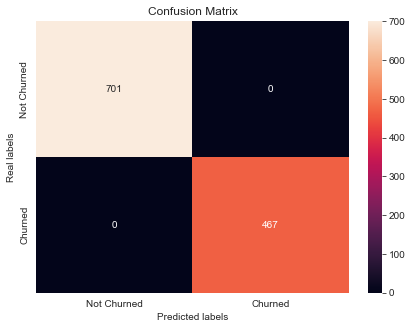

Score: 1.0
Accuracy:1.0
Precision:1.0
Recall:1.0
F1:1.0


In [122]:


y_pred = best_rf.predict(X_test[imp_features])
y_pred_prob = best_rf.predict_proba(X_test[imp_features])



produce_confusion('Churned', 'Un-Churned',y_test,y_pred)

print('Score:',best_rf.score(X_test[imp_features],y_test))
test_scores = apr(y_pred, y_test)


In [123]:

y_pred_proba = best_rf.predict_log_proba(X_test[feature_names])


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:902: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [124]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       701
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168



In [125]:
from sklearn.metrics import auc

# Calculate the false positive rates, true positive rates, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Set figure size
plt.figure(figsize=(10, 6))

# Plot ROC curve
sns.lineplot(x=fpr,y=tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Find 500 customers most likely to churn

In [ ]:
X_unchurned['churn_probability'] = best_rf.predict_proba(X_unchurned[imp_features]).T[0]
customers = X_unchurned.sort_values(by='churn_probability', axis=0, ascending=False)
customers_500 = customers['CustomerID'].head(500)



NameError: name 'X_unchurned' is not defined

In [ ]:
customers_500.to_csv('customers_500.csv',index=False)

### Churn Risk of Remaining Customers

In [ ]:
# find remaining customer id who are still un-churned
rem_customers = set(unchurned_df['CustomerID'])-set(customers_500)
# get a dataframe of remaining customers
rem_unchurned = X_unchurned[X_unchurned['CustomerID'].isin(rem_customers)]
rem_unchurned.shape

(4663, 38)

In [ ]:
# finds the churn probability of remaining customers
y_rem_pred_prob = best_rf.predict_proba(rem_unchurned[imp_features]).T[0]
remain_cust = rem_unchurned[['CustomerID']].copy()
remain_cust['churn_probability'] = y_rem_pred_prob
remain_cust = remain_cust.sort_values('churn_probability',ascending=False)


In [ ]:
remain_cust.to_csv('churn_probabilities.csv',index=False)